## Initialization

In [1]:
import math

import numpy as np
import pandas as pd

from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tqdm.auto import tqdm

## Load Data

The dataset is stored in the `/datasets/faces/` folder, there you can find
- The `final_files` folder with 7.6k photos
- The `labels.csv` file with labels, with two columns: `file_name` and `real_age`

Given the fact that the number of image files is rather high, it is advisable to avoid reading them all at once, which would greatly consume computational resources. We recommend you build a generator with the ImageDataGenerator generator. This method was explained in Chapter 3, Lesson 7 of this course.

The label file can be loaded as an usual CSV file.

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
print(labels.shape)
print(labels.info())
print(labels.head())

(7591, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB
None
    file_name  real_age
0  000000.jpg         4
1  000001.jpg        18
2  000002.jpg        80
3  000003.jpg        50
4  000004.jpg        17


In [3]:
train_datagen = ImageDataGenerator(rescale=1./255) 
#preprocessing brightness values (rescale)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(150, 150),
        batch_size=16,
        #class_mode 'sparse' is for string.
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


### Data Loading:

1) The data was readable and non-corrupt.

2) There are 7591 images total that correspond to respective file_name. and age values

3) The image files were successfully loaded through ImageDataGenerator and labeled as the train_gen_flow variable.

4) No classes were observed

## EDA

**Exploring the age distribution in the dataset**

In [4]:
#Age Histogram
sns.histplot(labels['real_age'], stat='density')

<AxesSubplot:xlabel='real_age', ylabel='Density'>

The density plot gives a clear depiction about the distribution. Values between 18 and 40 make up most of the data. The data diminishes trailing to the right of the plot, showing there's less observations of people in the age ranges higher than 40 years old.

In [5]:
#Age Boxplot
sns.boxplot(labels['real_age'])

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='real_age'>

We can see that the distribution is a bit skewed to the right. The box (IQR) area tells us that most of the values lie between ages 20 - 40 with the average being around age 30.

**Printing 10 photos for different ages**

In [6]:
#next() function obtains the picture-label pairs generated from 
#the .flow_from_dataframe
features, target = next(train_gen_flow)

print(features.shape) 

(16, 150, 150, 3)


The result is a four-dimensional tensor with sixteen 150x150 images with three color channels.

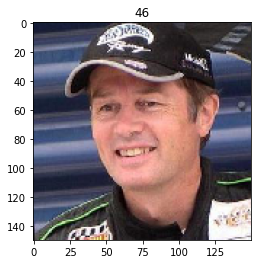

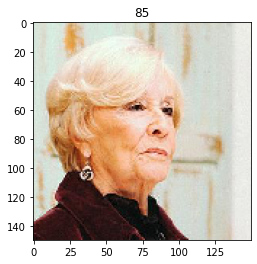

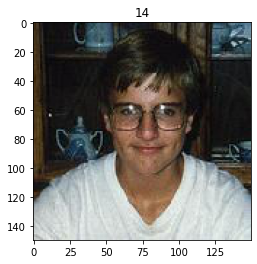

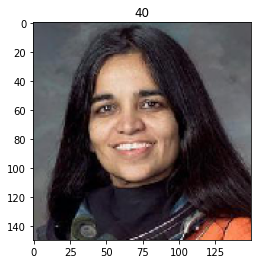

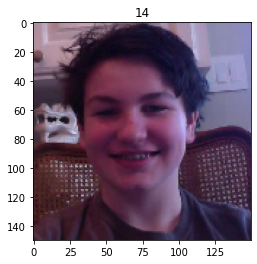

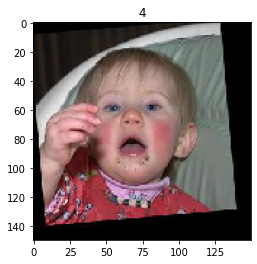

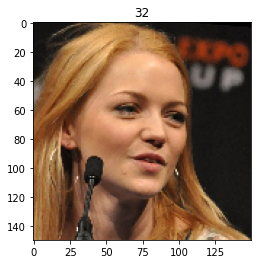

In [7]:
#We can loop through the picture-label pairs
#zip() function will pair each values with their corresponding indices 
#up to index 10

for age, image in zip(target[:15], features[:15]):
    plt.figure() #allows plot of entire loop
    plt.title(age) #displaying the image's real age
    plt.imshow(image) #shows image

### EDA Findings:

1) Both density and boxplot graphs show that the data is a bit skewed to the right.

2) We have some rotated and greyscale images and so we will need to rotational augmentation in training

## Modelling

Define the necessary functions to train your model on the GPU platform and build a single script containing all of them along with the initialization section.

To make this task easier, you can define them in this notebook and run a ready code in the next section to automatically compose the script.

The definitions below will be checked by project reviewers as well, so that they can understand how you built the model.

In [8]:
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

In [9]:
def load_train(path):
    
    """
    It loads the train part of dataset from path
    """
    
    # place your code here
    
    #data generator
    labels = pd.read_csv(path + 'labels.csv') #loading the label half of the pair
    train_datagen = ImageDataGenerator(rescale=1./255,
                                       validation_split=0.25,
                                       rotation_range=25,
                                      horizontal_flip=True) #loading the image half of the pair w/ augmentations
    train_gen_flow = train_datagen.flow_from_dataframe(
    dataframe=labels,
    directory=path + 'final_files/',
    x_col='file_name',
    y_col='real_age',
    target_size=(150,150),
    batch_size=16,
    class_mode='raw',
    subset='training',
    seed=12345
    )

    return train_gen_flow

In [10]:
def load_test(path):
    
    """
    It loads the validation/test part of dataset from path
    """
    
    # place your code here
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(rescale=1./255,
                                     validation_split=0.25) #no augmentations on valid/test set
    test_gen_flow = test_datagen.flow_from_dataframe(
    dataframe=labels,
    directory=path + 'final_files/',
    x_col='file_name',
    y_col='real_age',
    target_size=(150,150),
    batch_size=16,
    class_mode='raw',
    subset='validation',
    seed=12345
    )

    return test_gen_flow

In [11]:
def create_model(input_shape):
    
    """
    It defines the model
    """
    
    # place your code here
    backbone=ResNet50(input_shape=input_shape,
                     weights='imagenet',
                     include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(12, activation='relu'))
    optimizer=Adam(lr=0.00045)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

    return model

In [12]:
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    """
    Trains the model given the parameters
    """
    
    # place your code here
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    
    model.fit(train_data,
              validation_data= test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

## Prepare the Script to Run on the GPU Platform

Given you've defined the necessary functions you can compose a script for the GPU platform, download it via the "File|Open..." menu, and to upload it later for running on the GPU platform.

N.B.: The script should include the initialization section as well. An example of this is shown below.

In [13]:
# prepare a script to run on the GPU platform

init_str = """import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

import inspect

def load_train(path):
    
    # place your code here
    
    #data generator
    labels = pd.read_csv(path + 'labels.csv') #loading the label half of the pair
    train_datagen = ImageDataGenerator(rescale=1./255,
                                       validation_split=0.25,
                                       rotation_range=25,
                                      horizontal_flip=True) #loading the image half of the pair w/ augmentations
    train_gen_flow = train_datagen.flow_from_dataframe(
    dataframe=labels,
    directory=path + 'final_files/',
    x_col='file_name',
    y_col='real_age',
    target_size=(150,150),
    batch_size=16,
    class_mode='raw',
    subset='training',
    seed=12345
    )

    return train_gen_flow

def load_test(path):
    
    # place your code here
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(rescale=1./255,
                                     validation_split=0.25) #no augmentations on valid/test set
    test_gen_flow = test_datagen.flow_from_dataframe(
    dataframe=labels,
    directory=path + 'final_files/',
    x_col='file_name',
    y_col='real_age',
    target_size=(150,150),
    batch_size=16,
    class_mode='raw',
    subset='validation',
    seed=12345
    )

    return test_gen_flow
def create_model(input_shape):
    
    # place your code here
    backbone=ResNet50(input_shape=input_shape,
                     weights='imagenet',
                     include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(12, activation='relu'))
    optimizer=Adam(lr=0.00045)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

    return model
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    
    # place your code here
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    
    model.fit(train_data,
              validation_data= test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model
"""

The cell below was used to run the model on the GPU platform by selecting it and using file|open to download it and upload onto Practicum's server.

In [14]:
#import inspect

#with open('run_model_on_gpu.py', 'w') as f:
    
    #f.write(init_str)
    #f.write('\n\n')
        
    #for fn_name in [load_train, load_test, create_model, train_model]:
        
        #src = inspect.getsource(fn_name)
        #f.write(src)
        #f.write('\n\n')

### Output

2022-05-20 21:39:59.488735: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer.so.6
2022-05-20 21:39:59.843221: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer_plugin.so.6
Using TensorFlow backend.
Found 5694 validated image filenames.
Found 1897 validated image filenames.
2022-05-20 21:40:09.303978: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2022-05-20 21:40:10.014965: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2022-05-20 21:40:10.015056: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2022-05-20 21:40:10.015088: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-05-20 21:40:10.279362: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2022-05-20 21:40:10.339607: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2022-05-20 21:40:10.920459: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2022-05-20 21:40:11.041932: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2022-05-20 21:40:11.042068: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2022-05-20 21:40:11.046151: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2022-05-20 21:40:11.046565: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
2022-05-20 21:40:11.209909: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2099990000 Hz
2022-05-20 21:40:11.215689: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x44cdcd0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-05-20 21:40:11.215735: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2022-05-20 21:40:11.599941: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x4553cf0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-05-20 21:40:11.599981: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-SXM2-32GB, Compute Capability 7.0
2022-05-20 21:40:11.602513: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2022-05-20 21:40:11.602585: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2022-05-20 21:40:11.602595: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-05-20 21:40:11.602625: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2022-05-20 21:40:11.602635: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2022-05-20 21:40:11.602643: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2022-05-20 21:40:11.602651: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2022-05-20 21:40:11.602659: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2022-05-20 21:40:11.607126: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2022-05-20 21:40:11.618326: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2022-05-20 21:40:16.610615: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1096] Device interconnect StreamExecutor with strength 1 edge matrix:
2022-05-20 21:40:16.610663: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1102]      0 
2022-05-20 21:40:16.610671: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1115] 0:   N 
2022-05-20 21:40:16.625742: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1241] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 30509 MB memory) -> physical GPU (device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:8b:00.0, compute capability: 7.0)
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 356 steps, validate for 119 steps
Epoch 1/20
2022-05-20 21:40:47.709587: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-05-20 21:40:51.232706: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 137s - loss: 244.4553 - mae: 11.8024 - val_loss: 382.6252 - val_mae: 14.6423
Epoch 2/20
356/356 - 60s - loss: 158.1784 - mae: 9.6144 - val_loss: 210.9692 - val_mae: 11.1184
Epoch 3/20
356/356 - 60s - loss: 140.1248 - mae: 9.0551 - val_loss: 204.0137 - val_mae: 10.6400
Epoch 4/20
356/356 - 60s - loss: 129.1119 - mae: 8.6576 - val_loss: 188.4670 - val_mae: 11.3022
Epoch 5/20
356/356 - 60s - loss: 116.4456 - mae: 8.2242 - val_loss: 160.2068 - val_mae: 9.5289
Epoch 6/20
356/356 - 60s - loss: 109.5218 - mae: 7.9675 - val_loss: 116.2834 - val_mae: 8.5271
Epoch 7/20
356/356 - 60s - loss: 102.7438 - mae: 7.6963 - val_loss: 190.3618 - val_mae: 10.5710
Epoch 8/20
356/356 - 60s - loss: 95.3465 - mae: 7.4498 - val_loss: 106.9684 - val_mae: 7.6705
Epoch 9/20
356/356 - 60s - loss: 90.4785 - mae: 7.2372 - val_loss: 151.8903 - val_mae: 9.5544
Epoch 10/20
356/356 - 60s - loss: 90.1497 - mae: 7.2433 - val_loss: 129.4294 - val_mae: 8.3714
Epoch 11/20
356/356 - 60s - loss: 77.2618 - mae: 6.6759 - val_loss: 107.6415 - val_mae: 7.5376
Epoch 12/20
356/356 - 60s - loss: 77.5244 - mae: 6.7114 - val_loss: 89.8258 - val_mae: 7.0794
Epoch 13/20
356/356 - 60s - loss: 72.4023 - mae: 6.4609 - val_loss: 141.6150 - val_mae: 9.0063
Epoch 14/20
356/356 - 60s - loss: 70.5957 - mae: 6.4557 - val_loss: 95.2021 - val_mae: 7.2021
Epoch 15/20
356/356 - 60s - loss: 65.2084 - mae: 6.1626 - val_loss: 93.3897 - val_mae: 7.3975
Epoch 16/20
356/356 - 60s - loss: 65.2338 - mae: 6.1983 - val_loss: 102.3369 - val_mae: 7.6400
Epoch 17/20
356/356 - 60s - loss: 63.1157 - mae: 6.0007 - val_loss: 170.7419 - val_mae: 10.1668
Epoch 18/20
356/356 - 61s - loss: 62.0911 - mae: 6.0355 - val_loss: 99.8850 - val_mae: 7.2988
Epoch 19/20
356/356 - 60s - loss: 58.9459 - mae: 5.8776 - val_loss: 98.5585 - val_mae: 7.3594
Epoch 20/20
356/356 - 60s - loss: 51.8898 - mae: 5.4557 - val_loss: 121.0711 - val_mae: 7.9815
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 9s - loss: 121.0711 - mae: 7.9815
Test MAE: 7.9815

## Conclusions

1) The model passed the desired target MAE.

2) The score was achieved by finding a balance between parameters tuning between learning rate, augmentations, epochs, and density units.

3) If model improvement is desired in the future, consluting these parameters should be considered.